# Museum Detection (COMP 6721)

Done by:

1. Bhavya Patel (40304250)
2. Yashesh Sorathia (40267022)
3. Chama Amri Toudrhi (40180557)

In [2]:
# Mount Google Drive to access dataset files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Extracting the dataset from the zip file
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/museum_train.zip", "r")
zip_ref.extractall()
zip_ref.close()
zip_ref_test = zipfile.ZipFile("/content/drive/MyDrive/test_images.zip", "r")
zip_ref_test.extractall()
zip_ref_test.close()

## Data Preparation and Initial Setup
This section imports necessary libraries and sets up the basic configuration for our image classification task. We'll be using PyTorch for building and training our CNN models.

In [4]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
# Define basic image transformations
# Resizes images to 64x64 and converts to tensor
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [6]:
# Load dataset from directory with basic transformations
dataset = ImageFolder(root='/content/museum_train', transform=transform)

In [7]:
# Split dataset into training and test sets (80-20 split)
# Using stratified sampling to maintain class distribution
indices = np.arange(len(dataset))

train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=dataset.targets, random_state=42)

# Create subsets
train_set = Subset(dataset, train_idx)
test_set = Subset(dataset, test_idx)

In [8]:
# Create data loaders for batch processing
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

## Model 1: Basic CNN Architecture

This is our first CNN model with:

* 2 convolutional layers (32 and 64 filters)
* Max pooling after each layer
* 2 fully connected layers
* ReLU activation functions

In [9]:
class Model_1(nn.Module):
    def __init__(self, num_classes):
        super(Model_1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128) # 16x16 from 64x64 with 2 pooling layers
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
# Initialize Model 1
num_classes = len(dataset.classes)
model_1 = Model_1(num_classes)
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.Adam(model_1.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 10 # Training epochs

In [11]:
# Train Model 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_1 = model_1.to(device)

for epoch in range(num_epochs):
    model_1.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad() # Reset gradients

        outputs = model_1(images) # Forward pass

        loss = criterion(outputs, labels) # Calculate loss

        loss.backward() # Backpropagation
        optimizer.step() # Update weights

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print epoch statistics
    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")

Epoch 1/10 | Loss: 0.3517 | Accuracy: 85.19%
Epoch 2/10 | Loss: 0.2786 | Accuracy: 89.49%
Epoch 3/10 | Loss: 0.2472 | Accuracy: 90.61%
Epoch 4/10 | Loss: 0.2303 | Accuracy: 91.15%
Epoch 5/10 | Loss: 0.2038 | Accuracy: 92.00%
Epoch 6/10 | Loss: 0.1905 | Accuracy: 92.61%
Epoch 7/10 | Loss: 0.1649 | Accuracy: 93.53%
Epoch 8/10 | Loss: 0.1341 | Accuracy: 94.71%
Epoch 9/10 | Loss: 0.1132 | Accuracy: 95.83%
Epoch 10/10 | Loss: 0.0858 | Accuracy: 96.88%


## Model Evaluation

After training each model, we evaluate its performance using standard metrics:

* Accuracy
* Precision
* Recall
* F1 Score
* Confusion Matrix

Evaluation Metrics:
Accuracy: 91.90%
Precision: 93.74%
Recall: 89.80%
F1 Score: 91.73%


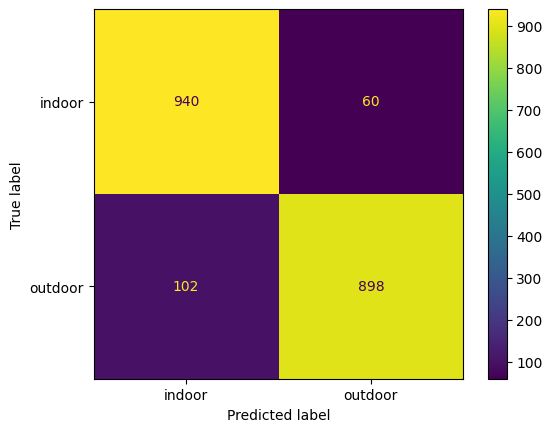

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

y_true = []
y_pred = []

# Evaluate Model 1 on test set
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_1(images)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1score = f1_score(y_true, y_pred, average='binary')

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1score * 100:.2f}%")

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=dataset.classes)

In [13]:
custom_test_dataset = ImageFolder(root='/content/test_images', transform=transform)
custom_test_loader = DataLoader(custom_test_dataset, batch_size=32, shuffle=False)

Evaluation on Custom Test Set:
Accuracy: 89.55%
Precision: 31.25%
Recall: 33.33%
F1 Score: 32.26%


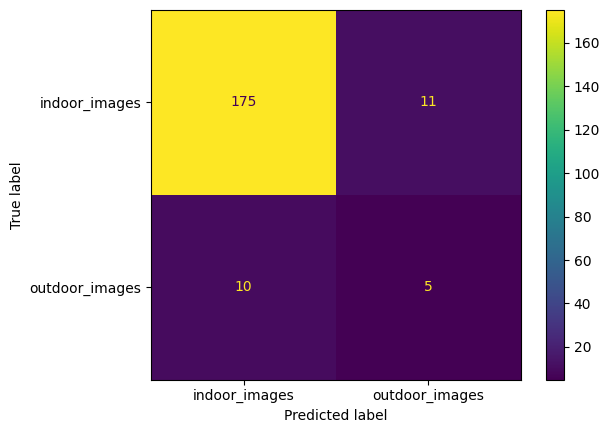

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

y_true = []
y_pred = []

model_1.eval()
with torch.no_grad():
    for images, labels in custom_test_loader:
        images = images.to(device)
        outputs = model_1(images)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1score = f1_score(y_true, y_pred, average='binary')

print("Evaluation on Custom Test Set:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1score * 100:.2f}%")

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=custom_test_dataset.classes)

In [15]:
torch.save(model_1, "museum_detection_cnn_model_1.pth")

## Model 2: Deeper CNN Architecture
This model adds an additional convolutional layer and reduces the size of the fully connected layer compared to Model 1.

In [16]:
class Model_2(nn.Module):
    def __init__(self, num_classes):
        super(Model_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128) # 8x8 from 64x64 with 3 pooling layers
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
# Initialize Model 2
num_classes = len(dataset.classes)
model_2 = Model_2(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)
num_epochs = 10

In [18]:
# Train Model 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_2 = model_2.to(device)

for epoch in range(num_epochs):
    model_2.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad() # Reset gradients

        outputs = model_2(images) # Forward pass

        loss = criterion(outputs, labels) # Calculate loss

        loss.backward() # Backpropagation
        optimizer.step() # Update weights

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")

Epoch 1/10 | Loss: 0.3631 | Accuracy: 84.46%
Epoch 2/10 | Loss: 0.2962 | Accuracy: 88.70%
Epoch 3/10 | Loss: 0.2816 | Accuracy: 89.54%
Epoch 4/10 | Loss: 0.2592 | Accuracy: 90.34%
Epoch 5/10 | Loss: 0.2438 | Accuracy: 90.67%
Epoch 6/10 | Loss: 0.2324 | Accuracy: 91.14%
Epoch 7/10 | Loss: 0.2116 | Accuracy: 91.66%
Epoch 8/10 | Loss: 0.2094 | Accuracy: 91.96%
Epoch 9/10 | Loss: 0.1910 | Accuracy: 92.69%
Epoch 10/10 | Loss: 0.1816 | Accuracy: 93.26%


Evaluation Metrics:
Accuracy: 91.05%
Precision: 89.97%
Recall: 92.40%
F1 Score: 91.17%


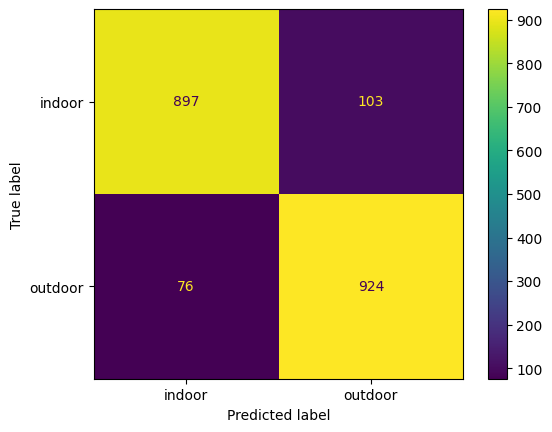

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

y_true = []
y_pred = []

# Evaluate Model 2 on test set
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_2(images)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1score = f1_score(y_true, y_pred, average='binary')

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1score * 100:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=dataset.classes)

In [20]:
custom_test_dataset = ImageFolder(root='/content/test_images', transform=transform)
custom_test_loader = DataLoader(custom_test_dataset, batch_size=32, shuffle=False)

Evaluation on Custom Test Set:
Accuracy: 92.04%
Precision: 46.15%
Recall: 40.00%
F1 Score: 42.86%


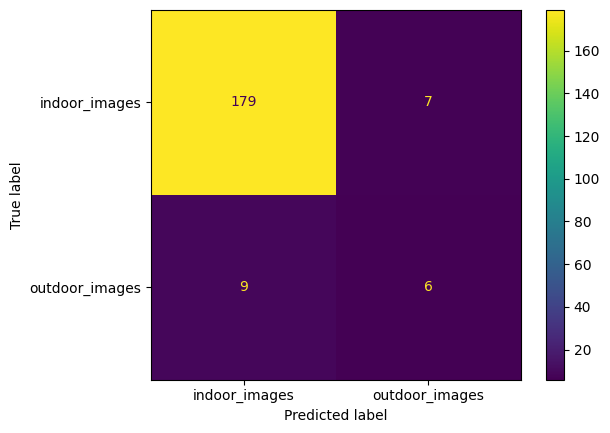

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

y_true = []
y_pred = []

model_2.eval()
with torch.no_grad():
    for images, labels in custom_test_loader:
        images = images.to(device)
        outputs = model_2(images)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1score = f1_score(y_true, y_pred, average='binary')

print("Evaluation on Custom Test Set:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1score * 100:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=custom_test_dataset.classes)

In [22]:
torch.save(model_2, "museum_detection_cnn_model_2.pth")

## Model 3: Enhanced CNN with Dropout and Normalization

This model introduces:

* More filters in convolutional layers
* Dropout for regularization
* Batch normalization
* Lower learning rate

In [23]:
# Advanced transformations with normalization
transform_3 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4, 0.4, 0.4],
                         std=[0.3, 0.3, 0.3])
])

In [24]:
# Load dataset with advanced transformations
dataset_3 = ImageFolder(root='/content/museum_train', transform=transform_3)

In [25]:
indices = np.arange(len(dataset))

train_idx_3, test_idx_3 = train_test_split(indices, test_size=0.2, stratify=dataset_3.targets, random_state=42)

# Create subsets
train_set_3 = Subset(dataset, train_idx_3)
test_set_3 = Subset(dataset, test_idx_3)

In [26]:
train_loader_3 = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader_3 = DataLoader(test_set, batch_size=32, shuffle=False)

In [27]:
# Initialize Model 3
class Model_3(nn.Module):
    def __init__(self, num_classes):
        super(Model_3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [28]:
# Initialize Model 3
num_classes = len(dataset.classes)
model_3 = Model_3(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.0005)
num_epochs = 10

In [29]:
# Train Model 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_3 = model_3.to(device)

for epoch in range(num_epochs):
    model_3.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_3:

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model_3(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")

Epoch 1/10 | Loss: 0.3241 | Accuracy: 87.11%
Epoch 2/10 | Loss: 0.2696 | Accuracy: 89.61%
Epoch 3/10 | Loss: 0.2331 | Accuracy: 90.90%
Epoch 4/10 | Loss: 0.2132 | Accuracy: 92.01%
Epoch 5/10 | Loss: 0.1858 | Accuracy: 92.70%
Epoch 6/10 | Loss: 0.1662 | Accuracy: 93.59%
Epoch 7/10 | Loss: 0.1357 | Accuracy: 94.85%
Epoch 8/10 | Loss: 0.1045 | Accuracy: 95.60%
Epoch 9/10 | Loss: 0.0885 | Accuracy: 96.65%
Epoch 10/10 | Loss: 0.0735 | Accuracy: 97.38%


Evaluation Metrics:
Accuracy: 91.35%
Precision: 92.67%
Recall: 89.80%
F1 Score: 91.21%


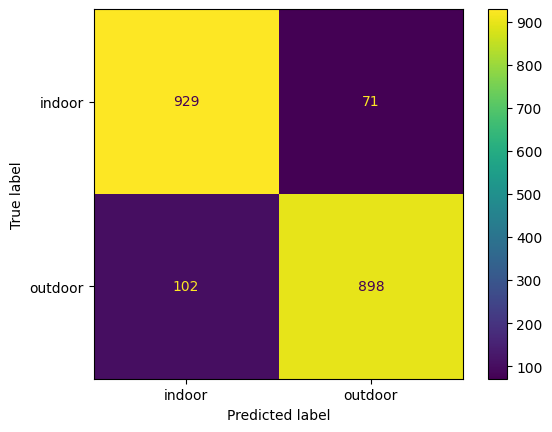

In [30]:
# Evaluate Model 3 on test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader_3:
        images = images.to(device)
        outputs = model_3(images)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1score = f1_score(y_true, y_pred, average='binary')

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1score * 100:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=dataset.classes)

In [31]:
custom_test_dataset = ImageFolder(root='/content/test_images', transform=transform_3)
custom_test_loader = DataLoader(custom_test_dataset, batch_size=32, shuffle=False)

Evaluation on Custom Test Set:
Accuracy: 89.05%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%


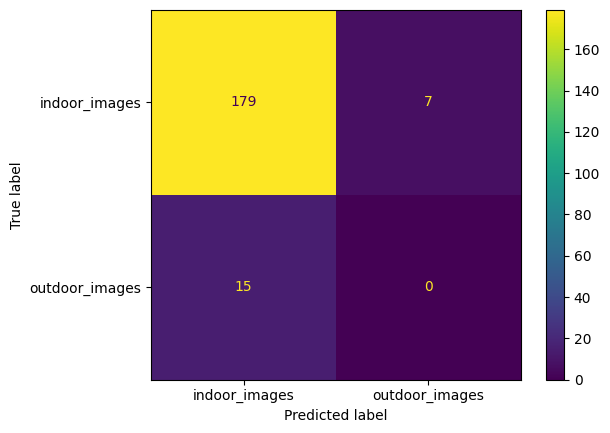

In [32]:
# Evaluate Model 3 on custom test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

y_true = []
y_pred = []

model_3.eval()
with torch.no_grad():
    for images, labels in custom_test_loader:
        images = images.to(device)
        outputs = model_3(images)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1score = f1_score(y_true, y_pred, average='binary')

print("Evaluation on Custom Test Set:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1score * 100:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=custom_test_dataset.classes)

In [33]:
torch.save(model_3, "museum_detection_cnn_model_3.pth")

## Model 4: CNN with Data Augmentation

This final model incorporates:

* Extensive data augmentation
* More convolutional layers
* Higher dropout rate
* Larger fully connected layers

In [34]:
# Advanced transformations with data augmentation
# Resizes images to 64x64, applies random horizontal flip, rotation, and color jitter
transform_4 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

In [35]:
# Load dataset with advanced transformations and data augmentation
aug_dataset = ImageFolder(root='/content/museum_train', transform=transform_4)

train_idx, test_idx = train_test_split(np.arange(len(aug_dataset)), test_size=0.2, stratify=aug_dataset.targets, random_state=42)

train_loader_4 = DataLoader(Subset(aug_dataset, train_idx), batch_size=32, shuffle=True)

test_loader_4 = DataLoader(Subset(aug_dataset, test_idx), batch_size=32, shuffle=False)

In [36]:
# Initialize Model 4
class Model_4(nn.Module):
    def __init__(self, num_classes):
        super(Model_4, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 64→32
        x = self.pool(torch.relu(self.conv2(x)))  # 32→16
        x = self.pool(torch.relu(self.conv3(x)))  # 16→8
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [37]:
# Initialize Model 4
num_classes = len(dataset.classes)
model_4 = Model_4(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_4.parameters(), lr=0.001)
num_epochs = 10

In [38]:
# Train Model 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_4 = model_4.to(device)

for epoch in range(num_epochs):
    model_4.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_4:

        images, labels = images.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_4(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass + optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")

Epoch 1/10 | Loss: 0.3619 | Accuracy: 84.94%
Epoch 2/10 | Loss: 0.2932 | Accuracy: 88.67%
Epoch 3/10 | Loss: 0.2746 | Accuracy: 89.33%
Epoch 4/10 | Loss: 0.2726 | Accuracy: 89.29%
Epoch 5/10 | Loss: 0.2557 | Accuracy: 89.90%
Epoch 6/10 | Loss: 0.2434 | Accuracy: 90.89%
Epoch 7/10 | Loss: 0.2340 | Accuracy: 90.86%
Epoch 8/10 | Loss: 0.2272 | Accuracy: 91.33%
Epoch 9/10 | Loss: 0.2224 | Accuracy: 91.64%
Epoch 10/10 | Loss: 0.2161 | Accuracy: 92.11%


Evaluation Metrics:
Accuracy: 91.90%
Precision: 91.73%
Recall: 92.10%
F1 Score: 91.92%


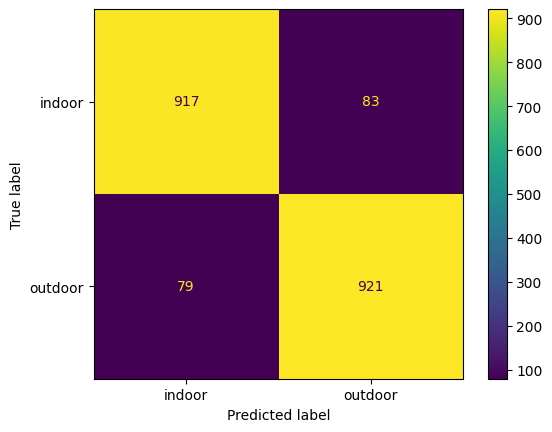

In [39]:
# Evaluate Model 4 on test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Collect all predictions and true labels
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader_4:
        images = images.to(device)
        outputs = model_4(images)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.numpy())

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')  # use 'macro' if >2 classes
recall = recall_score(y_true, y_pred, average='binary')
f1score = f1_score(y_true, y_pred, average='binary')

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1score * 100:.2f}%")

# Confusion matrix display
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=dataset.classes)

In [40]:
custom_test_dataset = ImageFolder(root='/content/test_images', transform=transform_4)
custom_test_loader = DataLoader(custom_test_dataset, batch_size=32, shuffle=False)

Evaluation on Custom Test Set:
Accuracy: 87.06%
Precision: 23.81%
Recall: 33.33%
F1 Score: 27.78%


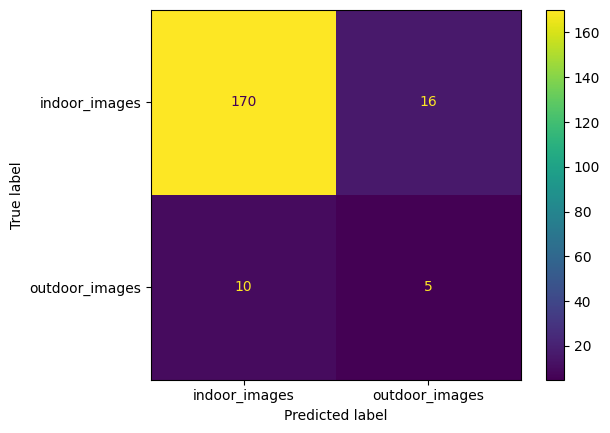

In [41]:
# Evaluate Model 4 on custom test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

y_true = []
y_pred = []

model_4.eval()
with torch.no_grad():
    for images, labels in custom_test_loader:
        images = images.to(device)
        outputs = model_4(images)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1score = f1_score(y_true, y_pred, average='binary')

print("Evaluation on Custom Test Set:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1score * 100:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=custom_test_dataset.classes)

In [42]:
torch.save(model_4, "museum_detection_cnn_model_4.pth")

In [43]:
# Load the saved model
from PIL import Image
from torchvision import transforms
import torch

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

img_path = '/content/test_images/indoor_images/test_image_86.JPG'
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)

model_4.eval()
with torch.no_grad():
    outputs = model_4(input_tensor)
    _, predicted = torch.max(outputs, 1)

predicted_class = dataset.classes[predicted.item()]
print(f"Predicted Class: {predicted_class}")

Predicted Class: indoor


## Model Comparison and Visualization
After training all models, we compare their performance metrics and visualize the results.

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Collect evaluation metrics for all models
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']
y_preds = []
y_true = []

# Get true labels once
for _, labels in test_loader:
    y_true.extend(labels.numpy())

# Function to get predictions from a model
def get_predictions(model):
    model.eval()
    preds = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
    return preds

# Get predictions for each model
y_pred_1 = get_predictions(model_1)
y_pred_2 = get_predictions(model_2)
y_pred_3 = get_predictions(model_3)
y_pred_4 = get_predictions(model_4)

# Evaluation metrics
accuracy = [
    accuracy_score(y_true, y_pred_1),
    accuracy_score(y_true, y_pred_2),
    accuracy_score(y_true, y_pred_3),
    accuracy_score(y_true, y_pred_4)
]

precision = [
    precision_score(y_true, y_pred_1, average='binary'),
    precision_score(y_true, y_pred_2, average='binary'),
    precision_score(y_true, y_pred_3, average='binary'),
    precision_score(y_true, y_pred_4, average='binary')
]

recall = [
    recall_score(y_true, y_pred_1, average='binary'),
    recall_score(y_true, y_pred_2, average='binary'),
    recall_score(y_true, y_pred_3, average='binary'),
    recall_score(y_true, y_pred_4, average='binary')
]

f1_score_values = [
    f1_score(y_true, y_pred_1, average='binary'),
    f1_score(y_true, y_pred_2, average='binary'),
    f1_score(y_true, y_pred_3, average='binary'),
    f1_score(y_true, y_pred_4, average='binary')
]

y_preds = [y_pred_1, y_pred_2, y_pred_3, y_pred_4]

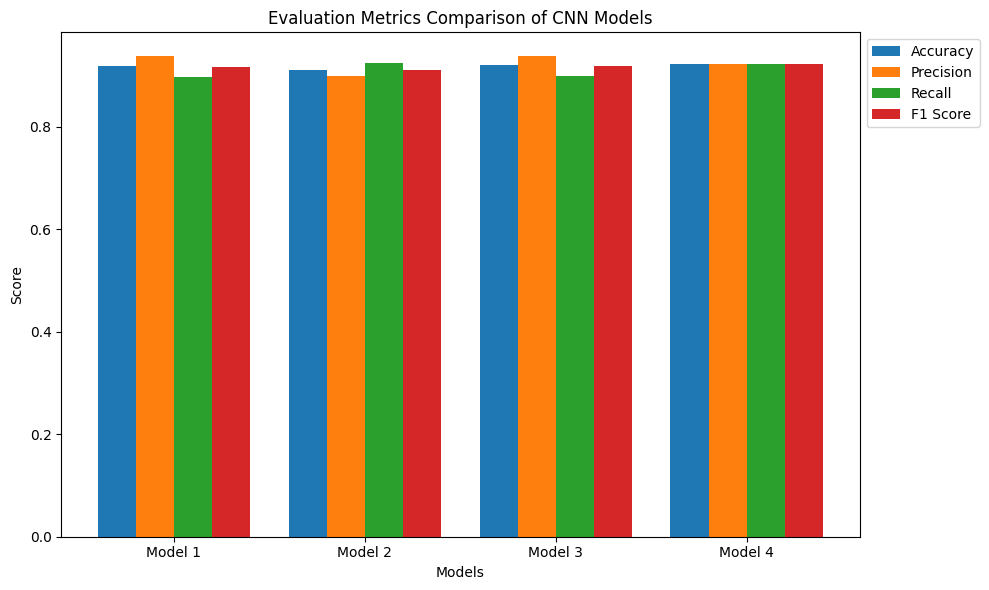

In [45]:
# Plotting the evaluation metrics
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(model_names))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 1.5*width, accuracy, width, label="Accuracy")
ax.bar(x - 0.5*width, precision, width, label="Precision")
ax.bar(x + 0.5*width, recall, width, label="Recall")
ax.bar(x + 1.5*width, f1_score_values, width, label="F1 Score")

ax.set_xlabel("Models")
ax.set_ylabel("Score")
ax.set_title("Evaluation Metrics Comparison of CNN Models")
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

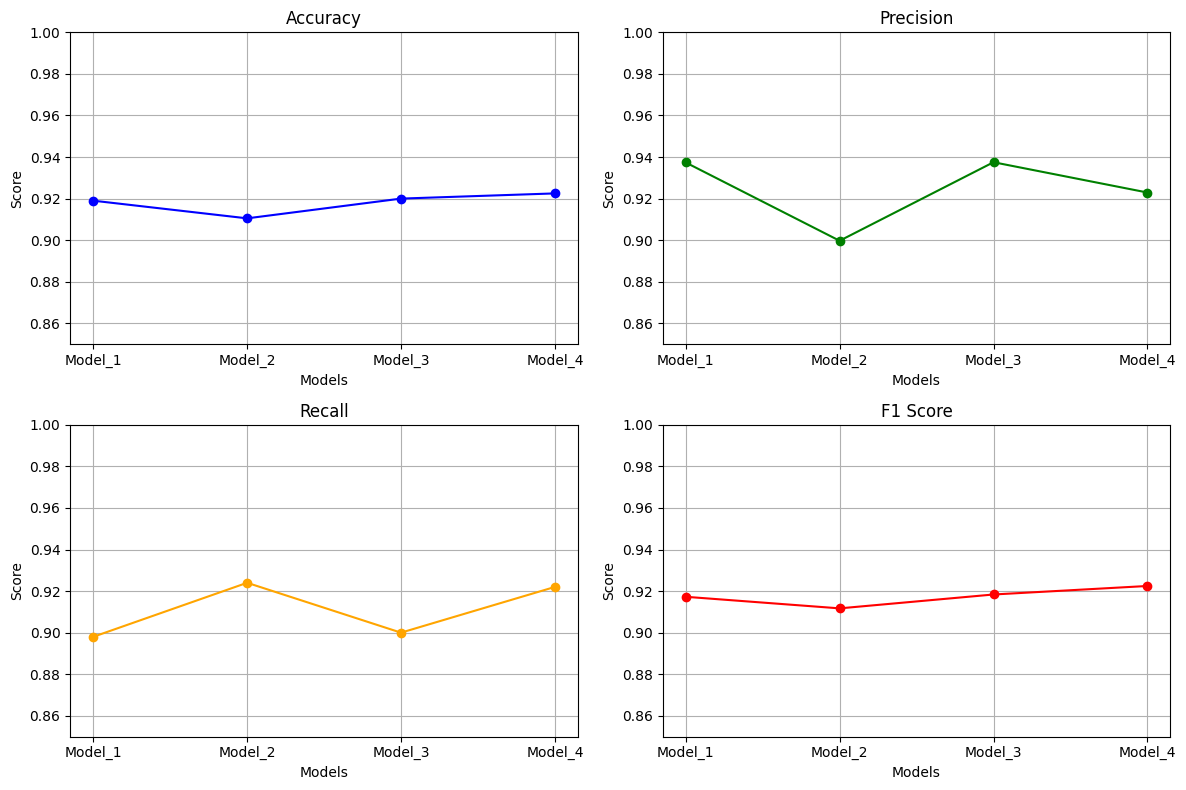

In [46]:
# Plotting individual metrics for each model
import matplotlib.pyplot as plt

# Your values (normalized between 0 and 1)
model_names = ["Model_1", "Model_2", "Model_3", "Model_4"]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Accuracy
axs[0, 0].plot(model_names, accuracy, marker='o', color='blue')
axs[0, 0].set_title("Accuracy")
axs[0, 0].set_ylim(0.85, 1)
axs[0, 0].grid(True)

# Precision
axs[0, 1].plot(model_names, precision, marker='o', color='green')
axs[0, 1].set_title("Precision")
axs[0, 1].set_ylim(0.85, 1)
axs[0, 1].grid(True)

# Recall
axs[1, 0].plot(model_names, recall, marker='o', color='orange')
axs[1, 0].set_title("Recall")
axs[1, 0].set_ylim(0.85, 1)
axs[1, 0].grid(True)

# F1 Score
axs[1, 1].plot(model_names, f1_score_values, marker='o', color='red')
axs[1, 1].set_title("F1 Score")
axs[1, 1].set_ylim(0.85, 1)
axs[1, 1].grid(True)

# Common labels and layout
for ax in axs.flat:
    ax.set_xlabel("Models")
    ax.set_ylabel("Score")

plt.tight_layout()
plt.show()

## Key Observations:

    1. Model Progression: Each subsequent model introduces more sophisticated techniques:

            Model 1: Basic CNN

            Model 2: Deeper architecture

            Model 3: Added normalization and dropout

            Model 4: Incorporated data augmentation

    2. Performance: Generally, later models show improved performance due to:

            Better regularization (dropout)

            More robust training (data augmentation)

            Optimized architectures

    3. Trade-offs: More complex models require:

            More computation resources

            Careful tuning of hyperparameters

            Longer training times